# _Gradients_ Cruise Data

Here we retrieve [SCOPE-Gradients](http://scope.soest.hawaii.edu/data/gradients/data/) cruise data from the [Simons' CMAP](https://cmap.readthedocs.io/en/latest/) data base.

<img src="../figs/cbiomes-01.png" alt="Drawing" style="height: 100px;"/>

### Import _pycmap_ , _Plots_ , and  _helper functions_

[PyCmap](https://github.com/simonscmap/pycmap) is the Python API that we will use in Julia, via the [PyCall.jl](https://github.com/JuliaPy/PyCall.jl) package, to query the CMAP data base. `Plots.jl` is A plotting package. `helper_functions.jl` contain a few convenience functions to access CMAP.

_Pre-requisites:_

- 1. _install the [PyCmap](https://github.com/simonscmap/pycmap) python package and its dependencies using `pip`_
- 2. _compile [PyCall.jl](https://github.com/simonscmap/pycmap) using external python distribution that installed `PyCmap`_
- 3. _obtain your own API key from [Simons' CMAP](https://simonscmap.com) (free; takes `<30s`)_
- 4. _import `pycmap` (via `pycall`), `Plots`, and `helper functions`_

_You may need to replace `your-own-API-key` (as outline below) with your own API key from [Simons' CMAP](https://simonscmap.com) and uncomment the command below._

In [1]:
if false
    run(`pip install pycmap`) #pycmap is used via PyCall later
    run(pipeline(`which python`,"whichpython.txt")) #external python path
    ENV["PYTHON"]=readline("whichpython.txt")
    import Pkg; Pkg.build("PyCall")
end

In [2]:
using PyCall
PyCmap = pyimport("pycmap")
#cmap = PyCmap.API(token="your-own-API-key")
cmap = PyCmap.API()

using Plots
include("helper_functions.jl")

Main.cbiomes_helpers

### Get Data Catalog

_The commented `df.to_csv` command writes the content of `df` to a new `catalog.csv` file. Alternatively, `Pandas.jl` can be used as also shown._

In [3]:
df = cmap.get_catalog();
#df.to_csv("catalog.csv")

#df=Pandas.DataFrame(cmap.get_catalog());
#to_csv(df,"catalog.csv")

### Download & File Data

Even though another method is preferred later on, one can simply download data from `CMAP` and store it to a `CSV` file that any software will be able to reload as shown below. 

The lists provided by `gradients_list()` contain `CMAP table` names associated with the [SCOPE-Gradients](http://scope.soest.hawaii.edu/data/gradients/data/) cruise data.

In [4]:
if false
    using DataFrames

    pth="../samples/gradients/"
    !isdir("$pth") ? mkdir("$pth") : nothing

    list0=cmap_helpers.tables("G3")
    for i in list0
        df=cmap.get_dataset(i)
        df.to_csv("$pth$i.csv")
    end

    #using CSV, DataFrames
    #df = CSV.File("$pth"*"tblKM1906_Gradients3_uway_optics.csv") |> DataFrame!
end

In addition, we can generate interpolation coefficients to sample context variables from `MITgcm` output. Using the `gcmfaces` toolbox in `Matlab` for example:


```
d='samples/gradients/'; l=dir([d '*csv']);
for f=1:length(l)
    tmp=readtable([d l(f).name]);
    lon=tmp.lon; lat=tmp.lat; interp=gcmfaces_interp_coeffs(lon(:),lat(:));
    save(fullfile(d,[l(f).name(1:end-4) '.mat']),'lon','lat','interp');
end
```

### Read Data + Meta-Data

As an example below we read, and then plot, the `LISST` data collected during the `Gradients 3` cruise.

In [5]:
s=cmap_helpers.get("tblKM1906_Gradients3_uway_optics","LISST_small")
m=cmap_helpers.get("tblKM1906_Gradients3_uway_optics","LISST_medium")
l=cmap_helpers.get("tblKM1906_Gradients3_uway_optics","LISST_large")

Dict{String,Any} with 8 entries:
  "Long_Name"   => "LISST C 20-100.0 micron"
  "Unit"        => "umol C/L"
  "lat"         => [21.2464, 21.2464, 21.2464, 21.2464, 21.2465, 21.2465, 21.24…
  "time"        => ["2019-04-10T00:39:37", "2019-04-10T00:42:07", "2019-04-10T0…
  "Variable"    => "LISST_large"
  "val"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, N…
  "lon"         => [-158.034, -158.037, -158.041, -158.045, -158.048, -158.052,…
  "Data_Source" => "Prof. Dr. Angelicque A. White, University of Hawaii, aewhit…

### Get Ancillary Data

In [6]:
pth="../samples/gradients/"
ssh=cbiomes_helpers.binary_get(pth,"tblKM1906_Gradients3_uway_optics","SSH")
ssh=merge(ssh,Dict("Unit" => "m", "Variable" => "SSH", "Long_Name" => "Sea Surface Height (Mean Dynamic Topography)"))

Dict{String,Any} with 7 entries:
  "lat"         => [21.2464; 21.2464; … ; 22.2572; 22.2496]
  "Long_Name"   => "Sea Surface Height (Mean Dynamic Topography)"
  "Unit"        => "m"
  "Variable"    => "SSH"
  "val"         => [0.701765; 0.701738; … ; 0.692622; 0.692603]
  "lon"         => [-158.034; -158.037; … ; -158.198; -158.2]
  "Data_Source" => "ECCOv4r2 (Gael Forget)"

### Plot Data vs Latitude

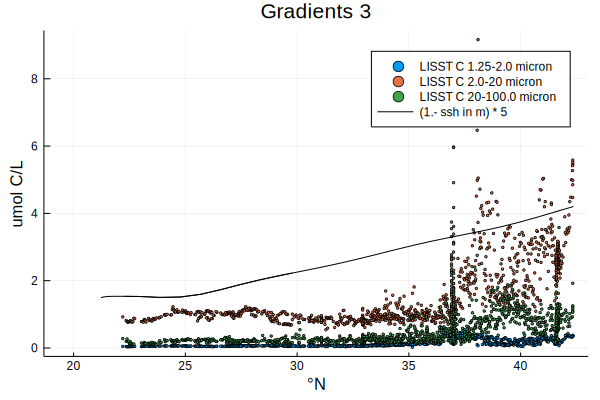

In [7]:
t=1:5:length(s["lat"])
scatter(s["lat"][t],s["val"][t],marker = 1.5,label=s["Long_Name"],
    xlabel="°N",ylabel=s["Unit"], title="Gradients 3")
scatter!(m["lat"][t],m["val"][t],marker = 1.5,label=m["Long_Name"])
scatter!(l["lat"][t],l["val"][t],marker = 1.5,label=l["Long_Name"])
plot!(ssh["lat"][t],(1.0.-ssh["val"][t]).*5.0,linecolor=:black,label="(1.- ssh in m) * 5")

### Plot Data vs Station ID

Here we plot `Gradients 1`, `Gradients 2`, and then `Gradients 3` one after the other.

_Note how strongly everything covaries with the ship moving back and forth across the gyre_

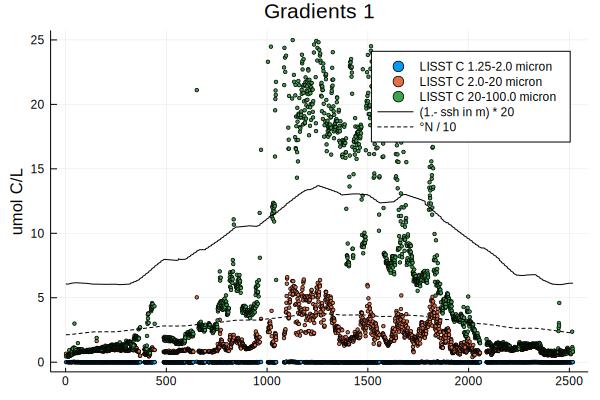

In [8]:
s1=cmap_helpers.get("tblKOK1606_Gradients1_uway_optics","LISST_small")
m1=cmap_helpers.get("tblKOK1606_Gradients1_uway_optics","LISST_medium")
l1=cmap_helpers.get("tblKOK1606_Gradients1_uway_optics","LISST_large")
ssh1=cbiomes_helpers.binary_get(pth,"tblKOK1606_Gradients1_uway_optics","SSH")

t=1:1:length(s1["lat"])
scatter(s1["val"][t],marker = 2,label=s["Long_Name"],
    ylabel=s["Unit"], title="Gradients 1")
scatter!(m1["val"][t],marker = 2,label=m["Long_Name"])
scatter!(l1["val"][t],marker = 2,label=l["Long_Name"])
plot!((1.0.-ssh1["val"][t]).*20.0,linecolor=:black,label="(1.- ssh in m) * 20")
plot!(s1["lat"][t]./10.,linecolor=:black,linestyle = :dash,label="°N / 10")

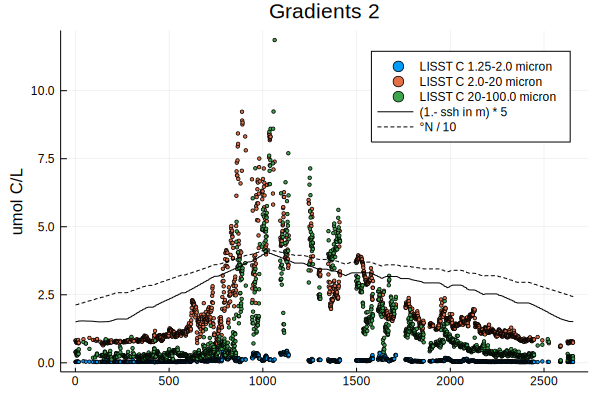

In [9]:
s2=cmap_helpers.get("tblMGL1704_Gradients2_uway_optics","LISST_small")
m2=cmap_helpers.get("tblMGL1704_Gradients2_uway_optics","LISST_medium")
l2=cmap_helpers.get("tblMGL1704_Gradients2_uway_optics","LISST_large")
ssh2=cbiomes_helpers.binary_get(pth,"tblMGL1704_Gradients2_uway_optics","SSH")

t=1:1:length(s2["lat"])
scatter(s2["val"][t],marker = 2,label=s["Long_Name"],
    ylabel=s["Unit"], title="Gradients 2")
scatter!(m2["val"][t],marker = 2,label=m["Long_Name"])
scatter!(l2["val"][t],marker = 2,label=l["Long_Name"])
plot!((1.0.-ssh2["val"][t]).*5.0,linecolor=:black,label="(1.- ssh in m) * 5")
plot!(s2["lat"][t]./10.0,linecolor=:black,linestyle = :dash,label="°N / 10")

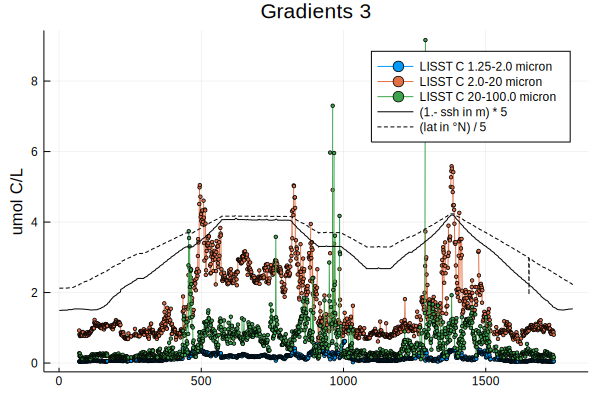

In [10]:
t=1:5:length(s["lat"])
plot(s["val"][t],marker = 2,label=s["Long_Name"],
    ylabel=s["Unit"], title="Gradients 3")
plot!(m["val"][t],marker = 2,label=m["Long_Name"])
plot!(l["val"][t],marker = 2,label=l["Long_Name"])
plot!((1.0.-ssh["val"][t]).*5.0,linecolor=:black,label="(1.- ssh in m) * 5")
plot!(s["lat"][t]./10.0,linecolor=:black,linestyle = :dash,label="(lat in °N) / 5")